<a href="https://colab.research.google.com/github/HoaNguyen55/PhoBert_News_Classification/blob/main/PhoBert_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive/')
!mkdir /content/drive/MyDrive/News
os.chdir('/content/drive/MyDrive/News/')


Mounted at /content/drive/


In [2]:
!git clone https://github.com/HoaNguyen55/PhoBert_News_Classification.git
os.chdir('/content/drive/MyDrive/News/PhoBert_News_Classification')

Cloning into 'PhoBert_News_Classification'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 36 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, Input, GlobalAveragePooling1D, Flatten
import tensorflow_hub as hub
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

!pip install vncorenlp
!mkdir -p vncorenlp/models/wordsegmenter  
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar  
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab  
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr  
!mv VnCoreNLP-1.1.1.jar vncorenlp/   
!mv vi-vocab vncorenlp/models/wordsegmenter/  
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 8.1 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=c36b50d9c7a544a0398f2d487e7d93b838e651a8620ef61df6c60d7b87a5c46b
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp
--2022-10-03 07:22:04--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  83.3MB/s    in 0.3s    

2022-10

In [4]:
 !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.8 MB/s 
     |████████████████████████████████| 163 kB 89.2 MB/s 
     |████████████████████████████████| 6.6 MB 70.6 MB/s 


In [5]:
# !wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
# !tar -xvf PhoBERT_base_transformers.tar.gz -C /content/drive/MyDrive/Covid_Sentiment/phobert-text-classification/vinai/phobert-base
# !mv ./vinai/phobert-base/PhoBERT_base_transformers/* ./vinai/phobert-base/.
# !rm -rf ./vinai/phobert-base/PhoBERT_base_transformers
# !mv ./vinai/phobert-base/model.bin ./vinai/phobert-base/pytorch_model.bin

# !wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
# !tar -xvf PhoBERT_base_transformers.tar.gz -C /content/drive/MyDrive/Covid_Sentiment/phobert-text-classification/vinai/phobert-base
# !mv ./vinai/phobert-base/PhoBERT_base_transformers/* ./vinai/phobert-base/.
# !rm -rf ./vinai/phobert-base/PhoBERT_base_transformers/
# !mv ./vinai/phobert-base/model.bin ./vinai/phobert-base/pytorch_model.bin

In [6]:
#@title
from vncorenlp import VnCoreNLP
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
from tqdm import tqdm
import pickle
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import os
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW, RobertaTokenizer, RobertaTokenizerFast, RobertaModel, AutoTokenizer
from datetime import datetime
import glob

def make_mask(batch_ids):
    batch_mask = []
    for ids in batch_ids:
        mask = [int(token_id > 0) for token_id in ids]
        batch_mask.append(mask)
    return torch.tensor(batch_mask)

def dataloader_from_text(text_file=None, tokenizer=None, classes=[], savetodisk=None, loadformdisk=None, segment=False, max_len=256, batch_size=16, infer=False):
    ids_padded, masks, labels = [], [], []
    if loadformdisk == None:
        #segementer
        if segment:
            rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')
        texts = []
        print("LOADDING TEXT FILE")
        with open(text_file, 'r') as f_r:
            for sample in tqdm(f_r):
                if infer:
                    text = sample.strip()
                    if segment:
                        text = rdrsegmenter.tokenize(text)
                        text = ' '.join([' '.join(x) for x in text])
                    texts.append(text)
                else:
                    splits = sample.strip().split(" ",1)
                    label = classes.index(splits[0])
                    text = splits[1]
                    if segment:
                        text = rdrsegmenter.tokenize(text)
                        text = ' '.join([' '.join(x) for x in text])
                    labels.append(label)
                    texts.append(text)

        print("TEXT TO IDS")
        ids = []
        for text in tqdm(texts):
            encoded_sent = tokenizer.encode(text)
            ids.append(encoded_sent)

        del texts
        # print("PADDING IDS")
        ids_padded = pad_sequences(ids, maxlen=max_len, dtype="long", value=0, truncating="post", padding="post")
        del ids
        # print("CREATE MASK")
        # for sent in tqdm(ids_padded):
        #     masks.append(make_mask(sent))

        if savetodisk != None and not infer:
            with open(savetodisk, 'wb') as f:
                pickle.dump(ids_padded, f)
                # pickle.dump(masks, f)
                pickle.dump(labels, f)
            print("SAVED IDS DATA TO DISK")
    else:
        print("LOAD FORM DISK")
        if loadformdisk != None:
            try:
                with open(savetodisk, 'rb') as f:
                    ids_padded = pickle.load(ids_padded, f)
                    # masks = pickle.load(masks, f)
                    labels = pickle.load(labels, f)
                print("LOADED IDS DATA FORM DISK")
            except:
                print("LOAD DATA FORM DISK ERROR!")
                
    print("CONVERT TO TORCH TENSOR")
    ids_inputs = torch.tensor(ids_padded)
    del ids_padded
    # masks = torch.tensor(masks)
    if not infer:
        labels = torch.tensor(labels)

    print("CREATE DATALOADER")
    if infer:
        # input_data = TensorDataset(ids_inputs, masks)
        input_data = TensorDataset(ids_inputs)
    else:
        input_data = TensorDataset(ids_inputs, labels)
        # input_data = TensorDataset(ids_inputs, masks, labels)
    input_sampler = SequentialSampler(input_data)
    dataloader = DataLoader(input_data, sampler=input_sampler, batch_size=batch_size)

    print("len dataloader:", len(dataloader))
    print("LOAD DATA ALL DONE")
    return dataloader

class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, num_labels, bert_model, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        if bert_model != None:
            self.roberta = bert_model
        else:
            self.roberta = RobertaModel.from_pretrained("./vinai/phobert-base")
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, num_labels)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        return x 

class BERTClassifier(torch.nn.Module):
    def __init__(self, num_labels):
        super(BERTClassifier, self).__init__()
        bert_classifier_config = RobertaConfig.from_pretrained(
            "./vinai/phobert-base/config.json",
            from_tf=False,
            num_labels = num_labels,
            output_hidden_states=False,
            )
        print("LOAD BERT PRETRAIN MODEL")
        self.bert_classifier = RobertaForSequenceClassification.from_pretrained(
            "./vinai/phobert-base/pytorch_model.bin",
            config=bert_classifier_config
            )

    def forward(self, input_ids, attention_mask, labels):
        output = self.bert_classifier(input_ids=input_ids,
                                    token_type_ids=None,
                                    attention_mask=attention_mask,
                                    labels=labels
                                    )
        return output

class ClassifierTrainner():
    def __init__(self, bert_model, train_dataloader, valid_dataloader, epochs=10, cuda_device="cpu", save_dir=None):

        if cuda_device == "cpu":
            self.device == torch.device("cpu")
        else:
            self.device = torch.device('cuda:{}'.format(cuda_device))

        self.model = bert_model
        if save_dir != None and os.path.exists(save_dir):
            print("Load weight from file:{}".format(save_dir))
            self.save_dir = save_dir
            epcho_checkpoint_path = glob.glob("{}/model_epoch*".format(self.save_dir))
            if len(epcho_checkpoint_path) == 0:
                print("No checkpoint found in: {}\nCheck save_dir...".format(self.save_dir))
            else:
                self.load_checkpoint(epcho_checkpoint_path)
                print("Restore weight successful from: {}".format(epcho_checkpoint_path))
        else:
            self.save_dir = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
            os.makedirs(self.save_dir)
            print("Training new model, save to: {}".format(self.save_dir))

        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.epochs = epochs
        # self.batch_size = batch_size

    def save_checkpoint(self, save_path):
        state_dict = {'model_state_dict': self.model.state_dict()}
        torch.save(state_dict, save_path)
        print(f'Model saved to ==> {save_path}')

    def load_checkpoint(self, load_path):
        state_dict = torch.load(load_path, map_location=self.device)
        print(f'Model restored from <== {load_path}')
        self.model.load_state_dict(state_dict['model_state_dict'])

    @staticmethod    
    def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        F1_score = f1_score(pred_flat, labels_flat, average='macro')
        return accuracy_score(pred_flat, labels_flat), F1_score

    def train_classifier(self):
        self.model.to(self.device)
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
            ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)
        loss_train_list = []
        acurracy_train_list = []
        acurracy_val_list = []
        loss_val_list = []
        best_valid_loss = 999999
        best_eval_accuracy = 0
                
        for epoch_i in range(0, self.epochs):
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, self.epochs))
            print('Training...')
            total_loss = 0
            train_accuracy = 0
            train_f1 = 0
            nb_train_steps = 0
            self.model.train()
            
            for step, batch in enumerate(self.train_dataloader):
                b_input_ids = batch[0].to(self.device)
                b_input_mask = make_mask(batch[0]).to(self.device)
                b_labels = batch[1].to(self.device)

                self.model.zero_grad()
                outputs = self.model(b_input_ids, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels
                                    )
                loss = outputs[0]
                total_loss += loss.item()
                
                logits = outputs[1].detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                tmp_train_accuracy, tmp_train_f1 = self.flat_accuracy(logits, label_ids)
                train_accuracy += tmp_train_accuracy
                train_f1 += tmp_train_f1
                nb_train_steps += 1
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                print("[TRAIN] Epoch {}/{} | Batch {}/{} | Train Loss={} | Train Acc={}".format(epoch_i+1, self.epochs, step, len(self.train_dataloader), loss.item(), tmp_train_accuracy))
                
                if step % 100 == 0:
                    if step > 0:
                      accur_val, loss_val = self.validate_classifier(epoch_i+1, best_valid_loss, best_eval_accuracy)
                      best_eval_accuracy = accur_val
                      best_valid_loss = loss_val
                      acurracy_val_list.append(accur_val)
                      loss_val_list.append(loss_val)

                      avg_train_loss = total_loss / len(self.train_dataloader)
                      acurracy_each_steps = train_accuracy/nb_train_steps
                      print(" Train Accuracy: {0:.4f}".format(acurracy_each_steps))
                      acurracy_train_list.append(acurracy_each_steps)
                      print(" Train F1 score: {0:.4f}".format(train_f1/nb_train_steps))
                      print(" Train Loss: {0:.4f}".format(avg_train_loss))
                      loss_train_list.append(avg_train_loss)
            
        print("Training complete!")
        return acurracy_train_list, loss_train_list, acurracy_val_list, loss_val_list

    def validate_classifier(self, currentEpoch, best_valid_loss, best_eval_accuracy):
        print("Running Validation...")
        self.model.eval()
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        eval_f1 = 0
        for batch in self.valid_dataloader:
            b_input_mask = make_mask(batch[0]).to(self.device)
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_labels = batch
            with torch.no_grad():
                outputs = self.model(b_input_ids, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels
                                    )
                tmp_eval_loss, logits = outputs[0], outputs[1]
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                tmp_eval_accuracy, tmp_eval_f1 = self.flat_accuracy(logits, label_ids)
                eval_accuracy += tmp_eval_accuracy
                eval_loss += tmp_eval_loss
                eval_f1 += tmp_eval_f1
                nb_eval_steps += 1

        loss_val = eval_loss/nb_eval_steps
        print(" Valid Loss: {0:.4f}".format(loss_val))
        accur_val = eval_accuracy/nb_eval_steps
        print(" Valid Accuracy: {0:.4f}".format(accur_val))
        print(" Valid F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
        
        print("best_valid_loss = {0:.4f}".format(best_valid_loss))
        print("eval_loss = {0:.4f}".format(loss_val))

        if eval_loss > best_valid_loss:
            best_valid_loss_path = "{}/model_best_valoss_{}epochs.pth".format(self.save_dir, self.epochs)
            self.save_checkpoint(best_valid_loss_path)
        
        print("best_eval_accuracy = {0:.4f}".format(best_eval_accuracy))
        print("eval_accuracy = {0:.4f}".format(accur_val))

        if accur_val > best_eval_accuracy:
            best_eval_accuracy_path = "{}/model_best_valacc{}epochs.pth".format(self.save_dir, self.epochs)
            self.save_checkpoint(best_eval_accuracy_path)
        
        if currentEpoch == self.epochs:
            epoch_path = "{}/model_{}epoch.pth".format(self.save_dir, currentEpoch)
            self.save_checkpoint(epoch_path)
            # os.remove("{}/model_{}epoch.pth".format(self.save_dir, currentEpoch-1))

        return accur_val, loss_val.item()

    def plot_model(self, acurracy_train_list, loss_train_list, acurracy_val_list, loss_val_list):
      # list all data in history
      # summarize history for accuracy
      # import matplotlib 
      plt.plot(acurracy_train_list)
      plt.plot(acurracy_val_list)
      # formatter = matplotlib.ticker.StrMethodFormatter("{x:.3f}")
      # plt.gca().yaxis.set_major_formatter(formatter)
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'vald'], loc='upper left')
      plt.show()
      # summarize history for loss
      plt.plot(loss_train_list)
      plt.plot(loss_val_list)
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'vald'], loc='upper left')
      plt.show()

    def predict_dataloader(self, dataloader, classes, tokenizer):
        for batch in dataloader:
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask = batch
            with torch.no_grad():
                outputs = self.model(b_input_ids, 
                                    attention_mask=b_input_mask,
                                    labels=None
                                    )
                logits = outputs
                logits = logits.detach().cpu().numpy()
                pred_flat = np.argmax(logits, axis=1).flatten()
                print("[PREDICT] {}:{}".format(classes[int(pred_flat)], tokenizer.decode(b_input_ids)))

    def predict_text(self, text, classes, tokenizer, max_len=256):
      self.model.cuda()
      ids = tokenizer.encode(text)
      ids_padded = pad_sequences([ids], maxlen=max_len, dtype="long", value=0, truncating="post", padding="post")
      mask = [[int(token_id > 0)] for token_id in ids_padded[0]]
      input_ids = torch.tensor(ids_padded)
      input_mask = torch.tensor(mask)
      with torch.no_grad():
          logits = self.model(input_ids.cuda(), 
                          attention_mask=input_mask.cuda(),
                          labels=None)[0]
          logits = logits.detach().cpu().numpy()
          pred_flat = np.argmax(logits, axis=1).flatten()

      print("[PREDICT] \nTEXT: {}\nLABEL: {}".format(text, classes[pred_flat[1]]))


In [7]:
from huggingface_hub import hf_hub_download
# snapshot_download(repo_id="vinai/phobert-base")
hf_hub_download(repo_id="vinai/phobert-base", filename="config.json")
hf_hub_download(repo_id="vinai/phobert-base", filename="pytorch_model.bin")
hf_hub_download(repo_id="vinai/phobert-base", filename="bpe.codes")
hf_hub_download(repo_id="vinai/phobert-base", filename="tokenizer.json")
hf_hub_download(repo_id="vinai/phobert-base", filename="vocab.txt")

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

'/root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/667b55927a1571811539f27c0f374429a1c75759/vocab.txt'

In [8]:
!mkdir vinai
!chmod 777 vinai
!mkdir vinai/phobert-base
!chmod 777 vinai/phobert-base
!cp /root/.cache/huggingface/hub/models--vinai--phobert-base/snapshots/667b55927a1571811539f27c0f374429a1c75759/* vinai/phobert-base/.

In [22]:
classes = ['__label__sống_trẻ', '__label__thời_sự', '__label__công_nghệ', '__label__sức_khỏe', '__label__giáo_dục', '__label__xe_360', '__label__thời_trang', '__label__du_lịch', '__label__âm_nhạc', '__label__xuất_bản', '__label__nhịp_sống', '__label__kinh_doanh', '__label__pháp_luật', '__label__ẩm_thực', '__label__thế_giới', '__label__thể_thao', '__label__giải_trí', '__label__phim_ảnh']

train_path = 'train.txt'
test_path = 'test.txt'

MAX_LEN = 256
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", local_files_only=True)
train_dataloader = dataloader_from_text(train_path, 
                                        tokenizer=tokenizer, 
                                        classes=classes, 
                                        savetodisk=None, 
                                        max_len=MAX_LEN, 
                                        batch_size=32)
valid_dataloader = dataloader_from_text(test_path, 
                                        tokenizer=tokenizer, 
                                        classes=classes, 
                                        savetodisk=None, 
                                        max_len=MAX_LEN, 
                                        batch_size=32)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


LOADDING TEXT FILE


8054it [00:00, 30538.25it/s]


TEXT TO IDS


100%|██████████| 8054/8054 [00:19<00:00, 411.24it/s]


CONVERT TO TORCH TENSOR
CREATE DATALOADER
len dataloader: 252
LOAD DATA ALL DONE
LOADDING TEXT FILE


1281it [00:00, 50196.22it/s]


TEXT TO IDS


100%|██████████| 1281/1281 [00:02<00:00, 462.58it/s]

CONVERT TO TORCH TENSOR
CREATE DATALOADER
len dataloader: 41
LOAD DATA ALL DONE


In [23]:
# Bert model
bert_classifier_model = BERTClassifier(len(classes))
# Initialize model
bert_classifier_trainer = ClassifierTrainner(bert_model=bert_classifier_model, 
                                             train_dataloader=train_dataloader, 
                                             valid_dataloader=valid_dataloader, 
                                             epochs=5, 
                                             cuda_device="0") #cuda_device: "cpu"=cpu hoac 0=gpu0, 1=gpu1, 

LOAD BERT PRETRAIN MODEL


Some weights of the model checkpoint at ./vinai/phobert-base/pytorch_model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./vinai/phobert-base/pytorch

Training new model, save to: 03-10-2022_07-37-24


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


======== Epoch 1 / 5 ========
Training...
[TRAIN] Epoch 1/5 | Batch 0/252 | Train Loss=2.8872456550598145 | Train Acc=0.0625
[TRAIN] Epoch 1/5 | Batch 1/252 | Train Loss=2.880887985229492 | Train Acc=0.0625
[TRAIN] Epoch 1/5 | Batch 2/252 | Train Loss=2.908358573913574 | Train Acc=0.0625
[TRAIN] Epoch 1/5 | Batch 3/252 | Train Loss=2.8921031951904297 | Train Acc=0.125
[TRAIN] Epoch 1/5 | Batch 4/252 | Train Loss=2.9368934631347656 | Train Acc=0.03125
[TRAIN] Epoch 1/5 | Batch 5/252 | Train Loss=2.8807904720306396 | Train Acc=0.125
[TRAIN] Epoch 1/5 | Batch 6/252 | Train Loss=2.8094496726989746 | Train Acc=0.21875
[TRAIN] Epoch 1/5 | Batch 7/252 | Train Loss=2.8441741466522217 | Train Acc=0.0625
[TRAIN] Epoch 1/5 | Batch 8/252 | Train Loss=2.791451930999756 | Train Acc=0.15625
[TRAIN] Epoch 1/5 | Batch 9/252 | Train Loss=2.811542510986328 | Train Acc=0.1875
[TRAIN] Epoch 1/5 | Batch 10/252 | Train Loss=2.750427484512329 | Train Acc=0.28125
[TRAIN] Epoch 1/5 | Batch 11/252 | Train Loss=2

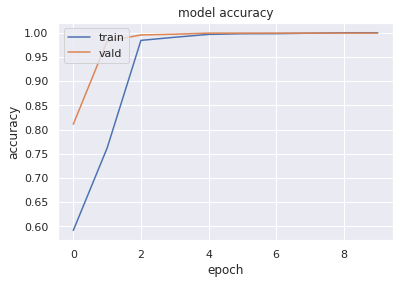

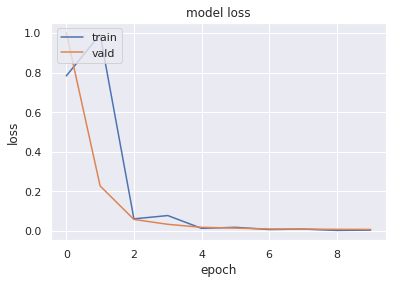

In [24]:
# Training model 
accur_train, loss_train, accur_val, loss_val = bert_classifier_trainer.train_classifier()

# Plot model
bert_classifier_trainer.plot_model(accur_train, loss_train, accur_val, loss_val)

In [17]:
# classes = ['__label__sống_trẻ', '__label__thời_sự', '__label__công_nghệ', '__label__sức_khỏe', '__label__giáo_dục', '__label__xe_360', '__label__thời_trang', '__label__du_lịch', '__label__âm_nhạc', '__label__xuất_bản', '__label__nhịp_sống', '__label__kinh_doanh', '__label__pháp_luật', '__label__ẩm_thực', '__label__thế_giới', '__label__thể_thao', '__label__giải_trí', '__label__phim_ảnh']

# Load model from saved file
load_model = torch.load('/content/drive/MyDrive/News/PhoBert_News_Classification/03-10-2022_07-23-14/model_5epoch.pth')
model = BERTClassifier(len(classes))
model.load_state_dict(load_model['model_state_dict']) # Load state dict, include input_ids and attention_mask

LOAD BERT PRETRAIN MODEL


Some weights of the model checkpoint at ./vinai/phobert-base/pytorch_model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./vinai/phobert-base/pytorch

<All keys matched successfully>

In [25]:
text = 'Ô tô Trung Quốc vào Việt Nam từ cách đây 2 thập niên và đến nay vẫn bị mang tiếng "nhái" thiết kế nhiều thương hiệu tên tuổi. Nhắc đến ô tô Trung Quốc, bên cạnh chất lượng bị nghi ngờ thì trong suy nghĩ và định kiến của người Việt, nhiều mẫu xe đến từ bên kia biên giới không có bản sắc mà thường "nhái" theo các thương hiệu tên tuổi trên thế giới. Kể từ khi xe Trung Quốc vào Việt Nam cách đây hơn 2 thập niên và đến hiện tại, yếu tố nhái kiểu dáng vẫn còn tồn tại. Ưu điểm của những xe nhái thiết kế là có giá rẻ hơn rất nhiều so với xe thật. Cho dù công nghệ, vận hành khó có thể bằng nhưng một số mẫu ô tô nhái của Trung Quốc vẫn có phân khúc khách hàng riêng. Dưới đây là một số mẫu xe điển hình như vậy đã bán ở Việt Nam.'
bert_classifier_trainer.predict_text(classes=classes, text=text, tokenizer=tokenizer, max_len=256)

[PREDICT] 
TEXT: Ô tô Trung Quốc vào Việt Nam từ cách đây 2 thập niên và đến nay vẫn bị mang tiếng "nhái" thiết kế nhiều thương hiệu tên tuổi. Nhắc đến ô tô Trung Quốc, bên cạnh chất lượng bị nghi ngờ thì trong suy nghĩ và định kiến của người Việt, nhiều mẫu xe đến từ bên kia biên giới không có bản sắc mà thường "nhái" theo các thương hiệu tên tuổi trên thế giới. Kể từ khi xe Trung Quốc vào Việt Nam cách đây hơn 2 thập niên và đến hiện tại, yếu tố nhái kiểu dáng vẫn còn tồn tại. Ưu điểm của những xe nhái thiết kế là có giá rẻ hơn rất nhiều so với xe thật. Cho dù công nghệ, vận hành khó có thể bằng nhưng một số mẫu ô tô nhái của Trung Quốc vẫn có phân khúc khách hàng riêng. Dưới đây là một số mẫu xe điển hình như vậy đã bán ở Việt Nam.
LABEL: __label__xe_360
